In [66]:
import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from matplotlib import pylab as plt
import scipy.stats

import os, sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from project.data.make_steps import make_data_dict, step_detection

In [2]:
data_dict1 = make_data_dict('00010100_s001_t000')
data_dict2 = make_data_dict('00010102_s001_t000')
steps1 = step_detection(data_dict1, 'FP1')
steps2 = step_detection(data_dict2, 'FP1')
step1 = steps1[0]
step2 = steps2
data1 = data_dict1['FP1'][step1[0]:step1[1] - 10000]
data2 = data_dict2['FP1'][step2[0]:step2[1]]
print(data1, data2)

[ 3.84556184e-05  3.67771529e-05  3.40305730e-05 ... -2.28846657e-05
 -2.33424290e-05 -2.05958491e-05] [7.06516381e-05 7.58396223e-05 7.69077367e-05 ... 3.50000000e-09
 3.50000000e-09 3.50000000e-09]


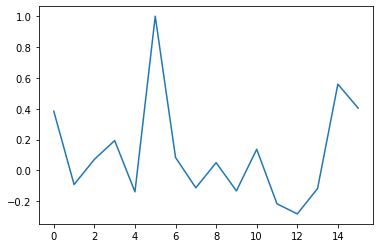

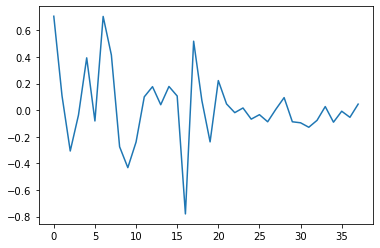

[ 0.38455618 -0.09151766  0.07175125  0.19382147 -0.13881987  1.00101078
  0.08395827 -0.11287995  0.05038896 -0.13271636  0.13736399 -0.21663964
 -0.28225238 -0.11745758  0.56003212  0.40439259] [ 0.70651638  0.10837232 -0.30666642 -0.03658607  0.39371145 -0.08083652
  0.7049905   0.41507374 -0.27462299 -0.43178839 -0.2395278   0.10074293
  0.17703681  0.0412337   0.17856269  0.10684644 -0.77968851  0.51883342
  0.07327713 -0.23800192  0.22281315  0.04733721 -0.01827553  0.01681965
 -0.06710362 -0.03353431 -0.08694003  0.00766439  0.09463942 -0.08694003
 -0.09456942 -0.12813873 -0.07625889  0.0275008  -0.08999179 -0.00759439
 -0.05337072  0.04581133]


In [3]:
data11 = (data1 * np.power(10, 4))[::10000]
data22 = (data2 * np.power(10, 4))[::10000]
plt.plot(data11)
plt.show()
plt.plot(data22)
plt.show()
print(data11, data22)

In [80]:
tfd = tfp.distributions

num_states = 9

initial_distribution = tfd.Categorical(probs=np.ones(shape=[num_states]))

daily_change_prob = 0.3
transition_probs = daily_change_prob / (num_states-1) * np.ones([num_states, num_states], dtype=np.float32)
np.fill_diagonal(transition_probs,1-daily_change_prob)
#transition_probs[0] = np.zeros(num_states)
#transition_probs[0][0] = 1
#transition_probs[-1] = np.flip(transition_probs[0])

print("Initial state:\n{}".format(initial_distribution))
print("Transition matrix:\n{}".format(transition_probs))

transition_distribution = tfd.Categorical(probs=transition_probs)

Initial state:
tfp.distributions.Categorical("Categorical", batch_shape=[], event_shape=[], dtype=int32)
Transition matrix:
[[0.7    0.0375 0.0375 0.0375 0.0375 0.0375 0.0375 0.0375 0.0375]
 [0.0375 0.7    0.0375 0.0375 0.0375 0.0375 0.0375 0.0375 0.0375]
 [0.0375 0.0375 0.7    0.0375 0.0375 0.0375 0.0375 0.0375 0.0375]
 [0.0375 0.0375 0.0375 0.7    0.0375 0.0375 0.0375 0.0375 0.0375]
 [0.0375 0.0375 0.0375 0.0375 0.7    0.0375 0.0375 0.0375 0.0375]
 [0.0375 0.0375 0.0375 0.0375 0.0375 0.7    0.0375 0.0375 0.0375]
 [0.0375 0.0375 0.0375 0.0375 0.0375 0.0375 0.7    0.0375 0.0375]
 [0.0375 0.0375 0.0375 0.0375 0.0375 0.0375 0.0375 0.7    0.0375]
 [0.0375 0.0375 0.0375 0.0375 0.0375 0.0375 0.0375 0.0375 0.7   ]]


In [84]:
observation_distribution = tfd.Normal(
    loc=0.3*np.ones(shape=[num_states], dtype='float32'),
    scale=0.3*np.ones(shape=[num_states], dtype='float32')
)

hmm = tfd.HiddenMarkovModel(
    initial_distribution=initial_distribution,
    transition_distribution=transition_distribution,
    observation_distribution=observation_distribution,
    num_steps=len(data11)
)

hmm.mean()

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([0.29999998, 0.30000004, 0.3000001 , 0.30000016, 0.3000002 ,
       0.30000022, 0.30000025, 0.30000025, 0.30000025, 0.30000025,
       0.30000025, 0.30000025, 0.30000025, 0.30000025, 0.30000025,
       0.30000025], dtype=float32)>

In [85]:
hmm.log_prob(tf.zeros(shape=[7]))

<tf.Tensor: shape=(), dtype=float32, numpy=-1.5047591>

In [86]:
hmm.posterior_mode(np.array(data11,dtype='float32'))

<tf.Tensor: shape=(16,), dtype=int64, numpy=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])>